<a href="https://colab.research.google.com/github/nisarahamedk/kaggle-riid/blob/master/notebooks/riid-pytorch-transformers-seq2seq-classifier-clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
%%capture
!pip install gcsfs

In [97]:
import multiprocessing
multiprocessing.cpu_count()

2

In [98]:
import math

import gcsfs
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader, ChainDataset
from tqdm import tqdm, trange

### Read the dataset

In [99]:
# DATA_PATH = "/kaggle/input/riiid-test-answer-prediction/"
DATA_PATH = "gs://kds-e80dfc3d272252bbf34c627d756f891826dab0c19f30ec0fc3ac1979"

In [100]:
dtypes_train = {
#     'row_id': 'int64',
#     'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
#     'content_type_id': 'int8',
    'task_container_id': 'int16',
#     'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
#     'prior_question_had_explanation': 'boolean'
    }

dtypes_questions = {
    "question_id": "",
    "bundle_id": "",
    "correct_answer": "",
    "part": "",
    "tags": "",
}

dtypes_lectures = {
    "lecture_id": "",
    "part": "",
    "tag": "",
    "type_of": "",
}

In [101]:
train_df = pd.read_csv(DATA_PATH + "/train.csv", dtype=dtypes_train, usecols=dtypes_train.keys(), nrows=1e7)
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time
0,115,5692,1,1,NaN
1,115,5716,2,1,37000.0
2,115,128,0,1,55000.0
3,115,7860,3,1,19000.0
4,115,7922,4,1,11000.0


In [102]:
questions_df = pd.read_csv(DATA_PATH + "/questions.csv")
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [103]:
lectures_df = pd.read_csv(DATA_PATH + "/lectures.csv")
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [104]:
# removing lecture rows.
train_df = train_df[train_df.answered_correctly != -1]

In [105]:
train_df = train_df.join(questions_df, on="content_id")
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,question_id,bundle_id,correct_answer,part,tags
0,115,5692,1,1,NaN,5692,5692,3,5,151
1,115,5716,2,1,37000.0,5716,5716,2,5,168
2,115,128,0,1,55000.0,128,128,0,1,131 149 92
3,115,7860,3,1,19000.0,7860,7860,0,1,131 104 81
4,115,7922,4,1,11000.0,7922,7922,1,1,131 149 92


In [106]:
# drop_cols = [
#              "row_id", 
#              "timestamp", 
#              "content_type_id", 
#              "user_answer", 
#              "prior_question_had_explanation", 
#              "question_id", 
#              "bundle_id", 
#              "correct_answer", 
#              "tags"
#              ]
# train_df = train_df.drop(drop_cols, axis=1)
# train_df.head()

In [107]:
# 0 is used for padding, so increment 1
indicator_cols = ["content_id", "task_container_id", "part"]
for c in indicator_cols:
  train_df[c] = train_df[c] + 1
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,question_id,bundle_id,correct_answer,part,tags
0,115,5693,2,1,NaN,5692,5692,3,6,151
1,115,5717,3,1,37000.0,5716,5716,2,6,168
2,115,129,1,1,55000.0,128,128,0,2,131 149 92
3,115,7861,4,1,19000.0,7860,7860,0,2,131 104 81
4,115,7923,5,1,11000.0,7922,7922,1,2,131 149 92


In [108]:
# convert milliseconds to minutes.
train_df['prior_question_elapsed_time'] = train_df["prior_question_elapsed_time"].fillna(0).astype(np.float32) / 60000
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,question_id,bundle_id,correct_answer,part,tags
0,115,5693,2,1,0.000000,5692,5692,3,6,151
1,115,5717,3,1,0.616667,5716,5716,2,6,168
2,115,129,1,1,0.916667,128,128,0,2,131 149 92
3,115,7861,4,1,0.316667,7860,7860,0,2,131 104 81
4,115,7923,5,1,0.183333,7922,7922,1,2,131 149 92


In [109]:
user_groups = train_df.groupby("user_id")
user_groups_arr = user_groups.apply(
    lambda rows: (
        rows["content_id"].values, 
        rows["task_container_id"].values, 
        rows["prior_question_elapsed_time"].values,
        rows["part"].values,
        rows["answered_correctly"].values,
        )
    )
np.stack(user_groups_arr[115])

array([[5.69300000e+03, 5.71700000e+03, 1.29000000e+02, 7.86100000e+03,
        7.92300000e+03, 1.57000000e+02, 5.20000000e+01, 5.10000000e+01,
        7.89700000e+03, 7.86400000e+03, 1.53000000e+02, 1.05000000e+02,
        1.09000000e+02, 7.90100000e+03, 7.90200000e+03, 7.97200000e+03,
        2.60000000e+01, 1.84000000e+02, 7.92700000e+03, 7.92800000e+03,
        5.00000000e+00, 7.98500000e+03, 4.60000000e+01, 1.86000000e+02,
        5.60000000e+01, 7.87700000e+03, 7.00000000e+00, 1.73000000e+02,
        7.89900000e+03, 1.76000000e+02, 1.01000000e+02, 7.86000000e+03,
        5.80000000e+01, 7.94900000e+03, 1.52000000e+02, 1.68000000e+02,
        7.89800000e+03, 7.88300000e+03, 7.96300000e+03, 1.27900000e+03,
        2.06600000e+03, 2.06500000e+03, 2.06400000e+03, 3.36400000e+03,
        3.36600000e+03, 3.36500000e+03],
       [2.00000000e+00, 3.00000000e+00, 1.00000000e+00, 4.00000000e+00,
        5.00000000e+00, 6.00000000e+00, 7.00000000e+00, 8.00000000e+00,
        9.00000000e+00,

In [110]:
# sort based on the # of interactions for a user
sorted_user_groups = user_groups.count().sort_values("content_id")
sorted_user_groups.head()

,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,question_id,bundle_id,correct_answer,part,tags
user_id,,,,,,,,,
121434886,1,1,1,1,1,1,1,1,1
38532797,1,1,1,1,1,1,1,1,1
19887248,1,1,1,1,1,1,1,1,1
60215278,1,1,1,1,1,1,1,1,1
108605579,1,1,1,1,1,1,1,1,1


In [111]:
sorted_uids = sorted_user_groups.index
sorted_uids

Int64Index([121434886,  38532797,  19887248,  60215278, 108605579, 190075469,
            122687953,  48251651, 126560148, 142134372,
            ...
            207268819, 197212993,  42525121, 177898308,  40224694, 111739511,
            195124785,  66756934,  39919444,  73289878],
           dtype='int64', name='user_id', length=39491)

Splitting load between workers

In [112]:
sorted_interactions_counts = user_groups.count().sort_values("content_id").cumsum().content_id.values
sorted_interactions_counts

array([      1,       2,       3, ..., 9774187, 9789042, 9804604])

#### Sequence to Sequence Dataset

In [113]:

class RiidS2SDataset(IterableDataset):
  def __init__(self, user_groups_arr, uids, int_counts, seq_len=128, batch_size=32, n_batches=None):
    super().__init__()
    self.user_groups_arr = user_groups_arr
    self.uids = uids
    self.int_counts = int_counts
    self.start = 0
    self.end = len(uids)
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.cache = []
    self.n_batches = n_batches
    if n_batches:
      self.__len = n_batches

  def __len__(self):
    """This is not correct len with multi worker"""
    b = 0
    for xb, yb in self:
      b += 1
    self.n_batches = b
    return b

  def create_batch(self, xs, ys):
    padded_xs, padded_ys = [], []
    maxlen = max(x.shape[0] for x in xs)
    for i in range(len(xs)):
      padded_xs.append(np.pad(xs[i], ((maxlen-len(xs[i]), 0), (0, 0)), constant_values=0))
      padded_ys.append(np.pad(ys[i], (maxlen-len(ys[i]), 0), constant_values=0))
    return padded_xs, padded_ys

  def __iter__(self):
      b = 0
      xs, ys = [], []
      for user_id in self.uids[self.start:self.end]:
        # build features and labels array
        user_arr = np.column_stack(self.user_groups_arr[user_id])
        y = user_arr[:, -1] # last col
        x = user_arr[:, :-1] # all but last col
        prev_y = np.pad(y, (1, 0), constant_values=2)[:-1] + 1 # prev_answered, pad left with 2 + ignore last el (shift right effect), +1 to keep 0 as pad token
        x = np.column_stack((x, np.expand_dims(prev_y, axis=0).T))
        
        # store and batch
        if y.shape[0] < self.seq_len:
          xs.append(x)
          ys.append(y)
          b += 1
          if b == self.batch_size:
              padded_xs, padded_ys = self.create_batch(xs, ys)
              yield np.stack(padded_xs, axis=1), np.stack(padded_ys) # reshape x to [seq_len, bs, n_features]
              b = 0
              xs, ys = [], []
        else:
          for i in range(0, y.shape[0], self.seq_len):
            start, end = i, i + self.seq_len
            if end > y.shape[0]:
              xs.append(x[start:])
              ys.append(y[start:])
            else:
              xs.append(x[start:end])
              ys.append(y[start:end])
            b += 1
            if b == self.batch_size:
              padded_xs, padded_ys = self.create_batch(xs, ys)
              yield np.stack(padded_xs, axis=1), np.stack(padded_ys) # reshape x to [seq_len, bs, n_features]
              b = 0
              xs, ys = [], []

In [114]:
def worker_init_fn(worker_id):

  worker_info = torch.utils.data.get_worker_info()

  dataset = worker_info.dataset # the dataset copy in this work

  # original start and end of the dataset
  overall_start = dataset.start
  overall_end = dataset.end
  int_counts = dataset.int_counts

  # change the start and end of the dataset copy in this worker.
  per_worker = math.ceil((int_counts[-1]) / float(worker_info.num_workers))
  worker_id = worker_info.id

  start = overall_start + np.searchsorted(int_counts, worker_id * per_worker, side="right")
  end = np.searchsorted(int_counts, (worker_id + 1) * per_worker, side="right")

  dataset.start = start
  dataset.end = min(end, overall_end)
  # dataset.cache = []
  # dataset.n_batches = len(dataset)
  # print(worker_id, dataset.start, dataset.end, len(dataset.cache))# , len(dataset))

In [115]:
riid_ds = RiidS2SDataset(user_groups_arr, sorted_uids, sorted_interactions_counts, seq_len=128, batch_size=128)
# len(riid_ds) # exhaust the iterator once to cache

In [116]:
riid_ds_iter = iter(riid_ds)
xb, yb = next(riid_ds_iter)
xb.shape, yb.shape

((7, 128, 5), (128, 7))

#### Dataloader

In [117]:
train_dl = DataLoader(riid_ds, batch_size=None, pin_memory=True, num_workers=4, worker_init_fn=worker_init_fn)

In [118]:
train_dl_iter = iter(train_dl)
x, y = next(train_dl_iter)
# x.shape, y.shape, x.dtype, y.dtype

In [119]:
len(train_dl)

797

Look ahead mask

In [120]:
  def generate_square_subsequent_mask(sz):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, True).masked_fill(mask == 1, False)
        return mask.bool()

### Transformer Sequence Classifier.

Positional Encoding

In [121]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [122]:
class TransformerClassifier(nn.Module):
    
    def __init__(self, n_tokens_dict, d_model=512, n_heads=8, hidden_dim=1024, n_layers=1, dropout=0):
        
        super().__init__()
        self.d_model = d_model
        
        # Transformer encoder blocks
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, hidden_dim, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        
        # Input embeddings for content_id, task_container_id, answered_correctly, prior_question_elapsed_time, part
        self.content_id_emb = nn.Embedding(n_tokens_dict["content_id"], d_model)
        self.task_container_id_emb = nn.Embedding(n_tokens_dict["task_container_id"], d_model)
        self.answered_correctly_emb = nn.Embedding(n_tokens_dict["answered_correctly"], d_model)
        self.part_emb = nn.Embedding(n_tokens_dict["part"], d_model)
        self.prior_question_elapsed_time_emb = nn.Linear(1, d_model, bias=False)
        # Positional Encoding
        self.pos_enc = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.out = nn.Linear(d_model, 1)
        
    def forward(self, x):

        seq_len, bs, n_features = x.size()
        device = x.device

        # padding mask
        src_key_padding_mask = torch.all(torch.eq(x, 0), dim=-1).T # shape [bs, seq_len]

        # look ahead mask
        look_ahead_mask = generate_square_subsequent_mask(seq_len).to(device)

        # input embedding
        content_id_emb = self.content_id_emb(x[..., 0].long())
        task_container_id_emb = self.task_container_id_emb(x[..., 1].long())
        # prior_question_elapsed_time_emb = self.prior_question_elapsed_time_emb(x[..., 2].unsqueeze(-1).float())
        part_emb = self.part_emb(x[..., 3].long())
        answered_correctly_emb = self.answered_correctly_emb(x[..., 4].long())

        
        # shape [seq_len, bs, d_model]
        input_emb = (content_id_emb 
                     + task_container_id_emb
                     + answered_correctly_emb
                     + part_emb
                     # + prior_question_elapsed_time_emb
                     )
        input_emb = input_emb * math.sqrt(self.d_model) # needed?

        input_emb = self.pos_enc(input_emb) # position encoding
        
        # transformer blocks
        z = self.transformer_encoder(input_emb, mask=look_ahead_mask) #, src_key_padding_mask=src_key_padding_mask) # shape [seq_len, bs, d_model]
        
        # output layer
        out = self.out(z) # shape [seq_len, bs, 1]
        
        return torch.sigmoid(out), src_key_padding_mask # out - shape [seq_len, bs, 1], mask - shape[bs, seq_len]
        


In [123]:
n_tokens_dict = {
    "content_id": max(train_df["content_id"]) + 1,
    "task_container_id": max(train_df["task_container_id"]) + 1,
    "answered_correctly": 4, # 0-padding, 1-incorrect, 2-correct, 3-fill value
    "part": max(train_df["part"]) + 1
}

n_tokens_dict

{'answered_correctly': 4,
 'content_id': 13524,
 'part': 9,
 'task_container_id': 10001}

In [124]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [125]:
model = TransformerClassifier(n_tokens_dict).to(device)
model

TransformerClassifier(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (content_id_emb): Embedding(13524, 512)
  (task_container_id_emb): Embedding(10001, 512)
  (answered_correctly_emb): Embedding(4, 512)
  (part_emb): Embedding(9, 512)
  (prior_question_elapsed_time_emb): Linear(in_features=1, out_features=512, bias=False)
  (pos_enc): PositionalEncod

In [126]:
xb = x.to(device)
print(f"Input : {xb.shape}")
preds, pad_mask = model(xb)
print(f"Output: {preds.shape}")

Input : torch.Size([7, 128, 5])
Output: torch.Size([7, 128, 1])


### Training

In [127]:
def masked_bce_loss(y_pred, y_true, pad_mask):
  """ https://github.com/pytorch/pytorch/issues/563#issuecomment-330103591 """
  # print(y_pred.shape, y_true.shape)
  y_pred = y_pred.permute(1, 2, 0) # [bs, 1, seq_len]
  y_true = y_true.unsqueeze(-1).permute(0, 2, 1).float() # [bs, 1, seq_len]
  loss = F.binary_cross_entropy(y_pred, y_true, reduction="none") # get individual loss
  pad_mask_flipped = ~pad_mask.unsqueeze(1) # notice the negation of mask # [bs, 1, seq_len]
  masked_loss = (pad_mask_flipped * loss).mean() # notice the negation of mask 

  return masked_loss

In [128]:
epochs = 2
opt = torch.optim.Adam(params=model.parameters(), lr=7e-4)
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=7e-4, steps_per_epoch=len(train_dl), epochs=epochs)
loss_func = masked_bce_loss

https://pytorch.org/tutorials/beginner/nn_tutorial.html#create-fit-and-get-data

In [129]:
def loss_batch(model, loss_func, X_batch, y_batch, opt=None):

  preds, pad_mask = model(X_batch)
  loss = loss_func(preds, y_batch, pad_mask)

  if opt is not None:
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), 0.25)
    opt.step()
    opt.zero_grad()

  return loss.detach()

In [130]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl=None, sched=None):
  epoch_losses = []
  epoch_lrs = []
  for e in range(epochs):
    # train
    lrs = []
    train_losses = []
    val_losses = []

    model.train()
    train_dl = tqdm(train_dl, position=0, leave=True)
    for X_batch, y_batch in train_dl:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      train_loss = loss_batch(model, loss_func, X_batch, y_batch, opt)
      train_losses.append(train_loss)

      train_loss_mean = sum(train_losses) / len(train_losses)
      lr = opt.param_groups[0]["lr"]
      lrs.append(lr)
      train_dl.set_description(f"Epoch: {e}, RunningLoss: {train_loss_mean:.3f}, InstantLoss: {train_loss:.3f}, LR: {lr:.6f}")
      if sched:
        sched.step()
        
    epoch_losses.append(train_loss_mean)
    epoch_lrs.append(lr)
    # eval
    # model.eval()
    # with torch.no_grad():
    #   val_losses, val_bss = zip(*[loss_batch(model, loss_func, X_batch, y_batch) for X_batch, y_batch in valid_dl])

    # val_loss = np.sum(np.multiply(val_losses, val_bss)) / np.sum(val_bss)
    # train_dl.set_description(f"Epoch: {e}, Loss: {train_loss}, Val Loss: {val_loss}")

  return epoch_losses, epoch_lrs#, val_losses

In [131]:
train_losses, lrs = fit(epochs, model, loss_func, opt, train_dl, sched=sched)

Epoch: 0, RunningLoss: 0.590, InstantLoss: 0.470, LR: 0.000569: 100%|█████████▉| 796/797 [00:58<00:00, 13.50it/s]
Epoch: 1, RunningLoss: 0.566, InstantLoss: 0.461, LR: 0.000000: 100%|█████████▉| 796/797 [00:58<00:00, 13.53it/s]


In [132]:
import matplotlib.pyplot as plt

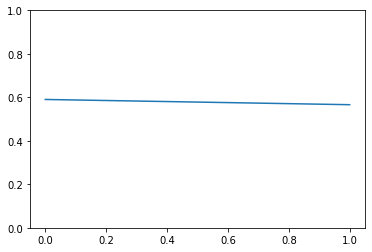

In [133]:
plt.ylim(top=1)
plt.plot(train_losses)

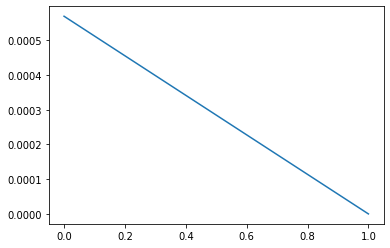

In [134]:
plt.plot(lrs)

In [135]:
xb = xb.to(device)
preds, _ = model(xb)

In [136]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [137]:
y_hat = preds.to("cpu").detach().numpy() > 0.5
y_hat = y_hat.astype(np.int8).flatten()
y_hat.shape

(896,)

In [140]:
y_true = yb.T.flatten()
y_true.shape

(896,)

In [141]:
accuracy_score(y_true, y_hat)

0.5513392857142857

In [142]:
precision_score(y_true, y_hat)

0.42134831460674155

In [143]:
recall_score(y_true, y_hat)

0.7075471698113207

In [146]:
roc_auc_score(y_true, preds.to("cpu").detach().numpy().flatten())

0.6943673695893452